# Import library

In [ ]:
import collections
import numpy as np
import re
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.data import Dataset
from tensorflow.train import Checkpoint

from tensorflow.nn import tanh, softmax
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Layer, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, Embedding
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy, SparseCategoricalCrossentropy

# Verify access to GPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3048374031365375221
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4284296575759941468
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Load data

Dataset: https://www.kaggle.com/datasets/hungnm/englishvietnamese-translation

In [ ]:
# Load English data
english_sentences = []
with open('en_sents.txt', "r") as en_file:
    english_sentences = en_file.read()
english_sentences = english_sentences.split('\n')
en_file.close()

# Load Vietnamese data
vietnamese_sentences = []
with open('vi_sents.txt', "r") as vi_file:
    vietnamese_sentences = vi_file.read()
vietnamese_sentences = vietnamese_sentences.split('\n')
vi_file.close()

In [ ]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('Vietnamese sample {}:  {}'.format(sample_i + 1, vietnamese_sentences[sample_i]))
    print()

English sample 1:  startseq Please put the dustpan in the broom closet endseq
Vietnamese sample 1:  startseq xin vui lòng đặt cái hót rác trong tủ chổi endseq

English sample 2:  startseq Be quiet for a moment. endseq
Vietnamese sample 2:  startseq im lặng một lát endseq

English sample 3:  startseq Read this endseq
Vietnamese sample 3:  startseq đọc này endseq

English sample 4:  startseq Tom persuaded the store manager to give him back his money. endseq
Vietnamese sample 4:  startseq tom thuyết phục người quản lý cửa hàng trả lại tiền cho anh ta. endseq

English sample 5:  startseq Friendship consists of mutual understanding endseq
Vietnamese sample 5:  startseq tình bạn bao gồm sự hiểu biết lẫn nhau endseq



# Vocabulary

In [ ]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
vietnamese_words_counter = collections.Counter([word for sentence in vietnamese_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(30)))[0]) + '"')
print()
print('{} Vietnamese words.'.format(len([word for sentence in vietnamese_sentences for word in sentence.split()])))
print('{} unique Vietnamese words.'.format(len(vietnamese_words_counter)))
print('10 Most common words in the Vietnamese dataset:')
print('"' + '" "'.join(list(zip(*vietnamese_words_counter.most_common(30)))[0]) + '"')

2229295 English words.
40267 unique English words.
10 Most common words in the English dataset:
"startseq" "endseq" "to" "I" "the" "Tom" "a" "you" "is" "of" "in" "was" "that" "for" "have" "He" "The" "me" "be" "his" "and" "on" "with" "it" "I'm" "my" "do" "not" "this" "he"

2629867 Vietnamese words.
15004 unique Vietnamese words.
10 Most common words in the Vietnamese dataset:
"startseq" "endseq" "tôi" "bạn" "không" "có" "một" "tom" "đã" "của" "anh" "là" "ấy" "chúng" "sẽ" "thể" "với" "làm" "nói" "cho" "gì" "đó" "Tom" "Tôi" "ở" "ta" "đến" "muốn" "cô" "để"


# Preprocess

First, remove some special characters (.,?!"), then add 'startseq' and 'endseq' tokens

1. Tokenize the words
2. Add padding to make all the sequences the same length

Finally, create a preprocess pipeline

In [ ]:
# Preprocess the sequence
def init_preprocess(w):
    '''
    init_preprocess x
    :param x: a sentence
    :return: the preprocessed sentence
    '''
    # Remove the characters ."?,!
    w = re.sub("[\.\"\?\,\!]", "", w)

    # Add a start and stop token to detect the start and end of the sequence
    w = 'startseq ' + w + ' endseq'

    # Remove duplicate white space
    w = re.sub("(\s+)", " ", w)

    # To lowercase
    w = w.lower()

    return w

In [ ]:
# Demo
str = "I'm told   Tom, \"to clean his room      ?  !       \""
print(f"Before: {str}")
print("After: {}".format(init_preprocess(str)))

Before: I'm told   Tom, "to clean his room      ?  !       "
After: startseq i'm told tom to clean his room endseq


## Tokenize

In [ ]:
def tokenize(x):
    '''
    Tokenize x
    :param x: List of sentences to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    '''
    # for i in range(len(x)):
    #     x[i] = "startseq " + x[i] + " endseq"
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [ ]:
# Tokenizing demo
text_sentencs = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .'
]
text_tokenized, text_tokenizer = tokenize(text_sentencs)
print(text_tokenizer.word_index, "\n")
for sample_i, (sent, token_sent) in enumerate(zip(text_sentencs, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('     Input:  {}'.format(sent))
    print('     Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21} 

Sequence 1 in x
     Input:  The quick brown fox jumps over the lazy dog .
     Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
     Input:  By Jove , my quick study of lexicography won a prize .
     Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
     Input:  This is a short sentence .
     Output: [18, 19, 3, 20, 21]


## Padding

In [ ]:
def padding(x, length=None):
    """
    Padding x
    :param x: List of sequences.
    :param length: Length to pad the sequence to. If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x, maxlen=length, padding='post')

In [ ]:
# Padding demo
test_padding = padding(text_tokenized)
for sample_i, (token_sent, padding_sent) in enumerate(zip(text_tokenized, test_padding)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('     Input:  {}'.format(np.array(token_sent)))
    print('     Output: {}'.format(padding_sent))

Sequence 1 in x
     Input:  [1 2 4 5 6 7 1 8 9]
     Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
     Input:  [10 11 12  2 13 14 15 16  3 17]
     Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
     Input:  [18 19  3 20 21]
     Output: [18 19  3 20 21  0  0  0  0  0]


## Preprocess pipeline

In [ ]:
def preprocess(in_sents, out_sents):
    in_sents = [init_preprocess(sent) for sent in in_sents]
    out_sents = [init_preprocess(sent) for sent in out_sents]

    preprocess_in, in_tokenizer = tokenize(in_sents)
    preprocess_out, out_tokenizer = tokenize(out_sents)

    preprocess_in = padding(preprocess_in)
    preprocess_out = padding(preprocess_out)

    return preprocess_in, preprocess_out, in_tokenizer, out_tokenizer

In [ ]:
preprocess_en, preprocess_vi, en_tokenizer, vi_tokenizer = preprocess(english_sentences, vietnamese_sentences)

max_en_sequence_length = preprocess_en.shape[1]
max_vi_sequence_length = preprocess_vi.shape[1]
en_vocab_size = len(en_tokenizer.word_index) + 1 # +1 for padding token
vi_vocab_size = len(vi_tokenizer.word_index) + 1 # +1 for padding token

print('Data Preprocessed')
print("Max English sentence length:", max_en_sequence_length)
print("Max Vietnamese sentence length:", max_vi_sequence_length)
print("English vocabulary size:", en_vocab_size)
print("Vietnamese vocabulary size:", vi_vocab_size)

# Split dataset into training set and validation set with ratio 8:2
en_train, en_val, vi_train, vi_val = train_test_split(preprocess_en, preprocess_vi, test_size=0.2)

Data Preprocessed
Max English sentence length: 49
Max Vietnamese sentence length: 63
English vocabulary size: 20811
Vietnamese vocabulary size: 7083


In [ ]:
print(en_train.shape, en_val.shape, vi_train.shape, vi_val.shape)

(203272, 49) (50818, 49) (203272, 63) (50818, 63)


# Models

In [ ]:
BUFFER_SIZE = len(en_train)
BATCH_SIZE = 1024
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

embedding_dim = 200
units = 256

In [ ]:
# Create proper dataset
dataset = Dataset.from_tensor_slices((en_train, vi_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Size of input and target batches
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([1024, 49]), TensorShape([1024, 63]))

## Encoder class

In [ ]:
# Encoder class
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units

        # Embed the vocab to a dense embedding
        self.embedding = Embedding(vocab_size, embedding_dim)

        # GRU layer
        self.gru = GRU(self.enc_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer='glorot_uniform')

    # Encoder network comprises an Embedding layer followed by a GRU layer
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    # To initialize the hidden state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [ ]:
encoder = Encoder(en_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (1024, 49, 256)
Encoder Hidden state shape: (batch size, units) (1024, 256)


# Attention class

In [ ]:
# Attention class - Additive Attention - a Soft Attention technique
class AdditiveAttention(Layer):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tanh(self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = AdditiveAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (1024, 256)
Attention weights shape: (batch_size, sequence_length, 1) (1024, 49, 1)


## Decoder class

In [ ]:
# Decoder class
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.dec_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer='glorot_uniform')
        self.fc = Dense(vocab_size)

        self.attention = AdditiveAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vi_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (1024, 7083)


## Optimizer and Loss Functions

In [ ]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = Checkpoint(optimizer=optimizer,
                        encoder=encoder,
                        decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden) -> float:
  loss = 0

  # tf.GradientTape() -- record operations for automatic differentiation
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = enc_hidden

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([vi_tokenizer.word_index['startseq']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # Pass enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Compute the loss
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # As this function is called per batch, compute the batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Get the model's variables
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Compute the gradients
  gradients = tape.gradient(loss, variables)

  # Update the variables of the model/network
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
import time

EPOCHS = 10

# Training loop
for epoch in range(EPOCHS):
  start = time.time()

  # Initialize the hidden state
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Loop through the dataset
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    # Call the train method
    batch_loss = train_step(inp, targ, enc_hidden)

    # Compute the loss (per batch)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # Save (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Output the loss observed until that epoch
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3241
Epoch 1 Batch 100 Loss 0.8436
Epoch 1 Loss 0.8496
Time taken for 1 epoch 303.27122163772583 sec

Epoch 2 Batch 0 Loss 0.7606
Epoch 2 Batch 100 Loss 0.6997
Epoch 2 Loss 0.7210
Time taken for 1 epoch 216.31064009666443 sec

Epoch 3 Batch 0 Loss 0.6850
Epoch 3 Batch 100 Loss 0.6186
Epoch 3 Loss 0.6441
Time taken for 1 epoch 216.55352091789246 sec

Epoch 4 Batch 0 Loss 0.6090
Epoch 4 Batch 100 Loss 0.5759
Epoch 4 Loss 0.5727
Time taken for 1 epoch 216.1922471523285 sec

Epoch 5 Batch 0 Loss 0.5452
Epoch 5 Batch 100 Loss 0.5126
Epoch 5 Loss 0.5063
Time taken for 1 epoch 215.40947937965393 sec

Epoch 6 Batch 0 Loss 0.4509
Epoch 6 Batch 100 Loss 0.4283
Epoch 6 Loss 0.4273
Time taken for 1 epoch 216.02438163757324 sec

Epoch 7 Batch 0 Loss 0.3759
Epoch 7 Batch 100 Loss 0.3500
Epoch 7 Loss 0.3516
Time taken for 1 epoch 215.4960105419159 sec

Epoch 8 Batch 0 Loss 0.3019
Epoch 8 Batch 100 Loss 0.2839
Epoch 8 Loss 0.2871
Time taken for 1 epoch 215.48630356788635 sec

Ep

# Test the model

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_vi_sequence_length, max_en_sequence_length))

    inputs = [en_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = pad_sequences([inputs], maxlen=max_en_sequence_length, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    encoder_out, encoder_hidden = encoder(inputs, hidden)

    decoder_hidden = encoder_hidden
    decoder_input = tf.expand_dims([vi_tokenizer.word_index['startseq']], 0)

    for t in range(max_vi_sequence_length):
        predictions, decoder_hidden, attention_weights = decoder(decoder_input, decoder_hidden, encoder_out)

        # Store the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # Get the prediction with the maximum attention
        predicted_id = tf.argmax(predictions[0]).numpy()

        # If <end> token is reached, return the result, input, and attention plot
        if vi_tokenizer.index_word[predicted_id] == 'endseq':
            return result, sentence, attention_plot

        # Append the token to the result
        result += vi_tokenizer.index_word[predicted_id] + ' '

        # The predicted ID is fed back into the model
        decoder_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# Plot and Predict

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

    return result

In [ ]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: startseq i am trying endseq
Predicted translation: tôi đang cố gắng 


<ipython-input-28-25f43572d771>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-28-25f43572d771>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


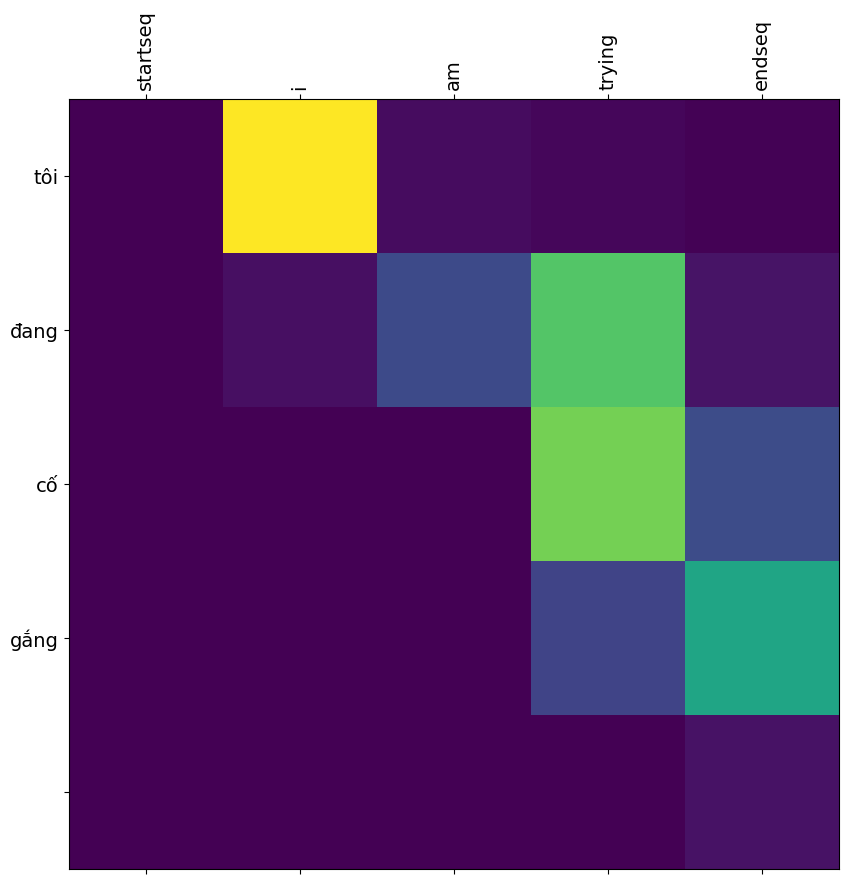

'tôi đang cố gắng '

In [ ]:
sent = "I am trying"

translate(init_preprocess(sent))

# Evaluate

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

Input: startseq please put the dustpan in the broom closet endseq
Predicted translation: xin vui lòng đặt cái cà phê trong tủ quần áo 


<ipython-input-4-25f43572d771>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-4-25f43572d771>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


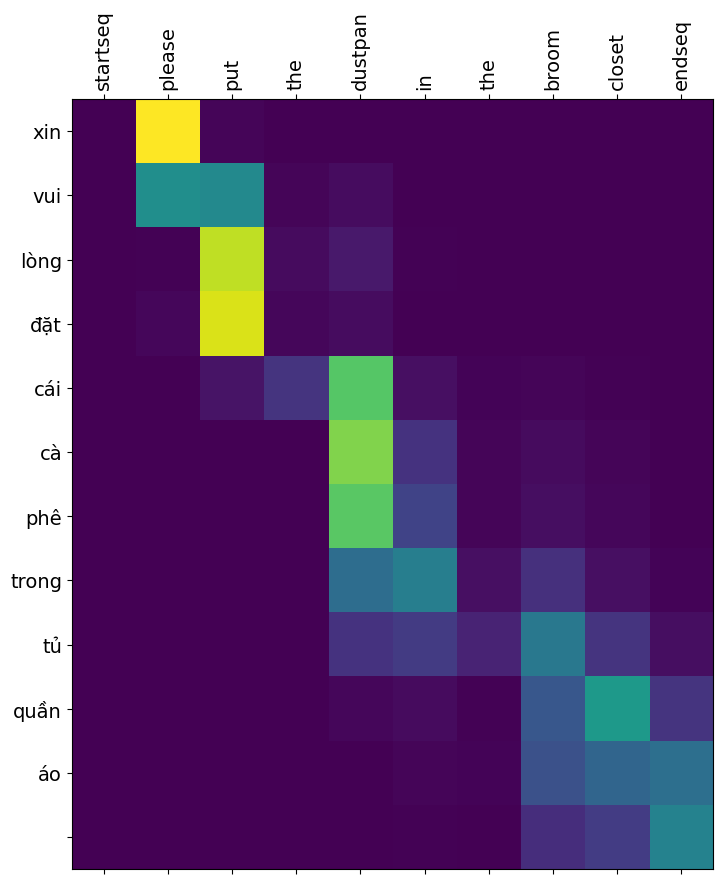

Input: Please put the dustpan in the broom closet
Truth Translation: xin vui lòng đặt cái hót rác trong tủ chổi
Predicted Translation: xin vui lòng đặt cái cà phê trong tủ quần áo 
BLEU Score: 0.40352786374639904


In [ ]:
sentence = en_sentences[0]
truth_translated_sentence = vi_sentences[0]
predict_translated_sentence = translate(sentence.lower())

print('Input: {}'.format(sentence))
print('Truth Translation: {}'.format(truth_translated_sentence))
print('Predicted Translation: {}'.format(predict_translated_sentence))
print('BLEU Score: {}'.format(sentence_bleu([truth_translated_sentence.split()], predict_translated_sentence.split())))